## __<u>Model Creation Template</u>__

### __0. Import Libraries & Redshift Credentials__

In [1]:
import pandas as pd
import numpy as np
from catnip.fla_redshift import FLA_Redshift
from sqlalchemy import null
from datetime import datetime

from prefect.blocks.system import Secret
from typing import Dict
from concurrent.futures import ThreadPoolExecutor

import missingno as msno
import matplotlib.pyplot as plt
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import GridSearchCV
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import classification_report
from sklearn.feature_selection import RFECV
import random

from sklearn.metrics import roc_auc_score
from sklearn.metrics import confusion_matrix
from sklearn.metrics import ConfusionMatrixDisplay
from sklearn.inspection import permutation_importance
from imblearn.over_sampling import SMOTE

In [2]:
def get_redshift_credentials() -> Dict:

    cred_dict = {
        "dbname": Secret.load("stellar-redshift-db-name").get(),
        "host": Secret.load("stellar-redshift-host").get(),
        "port": 5439,
        "user": Secret.load("stellar-redshift-user-name").get(),
        "password": Secret.load("stellar-redshift-password").get(),

        "aws_access_key_id": Secret.load("fla-s3-aws-access-key-id-east-1").get(),
        "aws_secret_access_key": Secret.load("fla-s3-aws-secret-access-key-east-1").get(),
        "bucket": Secret.load("fla-s3-bucket-name-east-1").get(),
        "subdirectory": "us-east-1",

        "verbose": False,
    }

    return cred_dict

with ThreadPoolExecutor(1) as pool:
    rs_creds = pool.submit(lambda: get_redshift_credentials()).result()

### __1. Missing Data Evaluation__

#### __1.1__ Import Data

For large data sets grab from the warehouse once and then download as a CSV to pull from after.

In [3]:
q = """
WITH base_table AS (
    SELECT DISTINCT
        '2023-24'::varchar AS season,
        purch_client_crm_id
    FROM
        custom.cth_v_ticket_subscription_2324
    WHERE
        is_comp = FALSE
    UNION ALL
    SELECT DISTINCT
        '2024-25'::varchar AS season,
        purch_client_crm_id
    FROM
        custom.cth_v_ticket_subscription_2425
    WHERE
        is_comp = FALSE
),
is_local AS (
    SELECT DISTINCT
        clients.crm_id,
        email,
        CASE
            WHEN addresses.is_local = TRUE THEN 1
            ELSE 0
        END AS is_local
    FROM
        custom.seatgeek_v_clients clients
    INNER JOIN
        custom.golden_record_v_addresses addresses USING (email)
),
subscribers AS (
    SELECT DISTINCT
        season::varchar,
        purchaser_ticketing_id,
        MAX(CASE WHEN ticket_type = 'Full' THEN 1 ELSE 0 END) AS "is_full",
        MAX(CASE WHEN ticket_type = 'Premier' OR ticket_type = 'Half' THEN 1 ELSE 0 END) AS "is_premier",
        SUM(gross_revenue) AS "total_spend",
        MAX(CASE WHEN manifest.arena_level_internal = 'Premium' THEN 1 ELSE 0 END) AS "is_premium",
        MAX(CASE WHEN manifest.arena_level_internal = 'Clubs' THEN 1 ELSE 0 END) AS "is_club",
        MAX(CASE WHEN manifest.arena_level_internal = 'Lowers' THEN 1 ELSE 0 END) AS "is_lower",
        MAX(CASE WHEN manifest.arena_level_internal = 'Uppers' THEN 1 ELSE 0 END) AS "is_upper",
        MAX(CASE WHEN is_renewal = TRUE THEN 0 ELSE 1 END) AS "is_rookie"
    FROM
        custom.cth_v_historical_plans ticket
    LEFT JOIN
        custom.cth_v_manifest_base manifest ON ticket.seat_id = manifest.seat_id
    WHERE
        season IN ('2023-24', '2024-25')
    GROUP BY
        season,
        purchaser_ticketing_id
    HAVING
        "total_spend" > 0
),
did_renew AS (
    SELECT DISTINCT
        season::varchar,
        purchaser_ticketing_id,
        CASE
            WHEN purchaser_ticketing_id IN (
                SELECT DISTINCT purchaser_ticketing_id
                FROM custom.cth_v_historical_plans
                WHERE season = '2024-25'
            ) THEN 1
            ELSE 0
        END AS "did_renew"
    FROM
        custom.cth_v_historical_plans
    WHERE
        season = '2023-24'
    UNION ALL
    SELECT DISTINCT
        season::varchar,
        purchaser_ticketing_id,
        CASE
            WHEN purchaser_ticketing_id IN (
                SELECT DISTINCT purchaser_ticketing_id
                FROM custom.cth_v_historical_plans
                WHERE season = '2025-26'
            ) THEN 1
            ELSE 0
        END AS "did_renew"
    FROM
        custom.cth_v_historical_plans
    WHERE
        season = '2024-25'
),
renewal_surveys AS (
    SELECT
        '2023-24'::varchar AS "season",
        contacts.email,
        contacts.primary_ticketing_id,
        MAX(
            CASE how_likely_are_you_to_renew_your_territory_membership_for_next_season
                WHEN 'Extremely Likely' THEN 5
                WHEN 'Likely' THEN 4
                WHEN 'Neutral' THEN 3
                WHEN 'Unlikely' THEN 2
                WHEN 'Extremely Unlikely' THEN 1
                ELSE 0
            END
        ) AS "renewal_likelihood_survey"
    FROM
        custom.formstack_v_stm_renewal_survey_2425 survey
    LEFT JOIN
        custom.korepss_v_contacts contacts ON survey.subscriber_key = contacts.sf_contactid
    GROUP BY
        contacts.email,
        contacts.primary_ticketing_id
    UNION ALL
    SELECT
        '2024-25'::varchar AS "season",
        contacts.email,
        contacts.primary_ticketing_id,
        MAX(
            CASE how_likely_are_you_to_renew_your_territory_membership_for_next_season
                WHEN 'Extremely Likely' THEN 5
                WHEN 'Likely' THEN 4
                WHEN 'Neutral' THEN 3
                WHEN 'Unlikely' THEN 2
                WHEN 'Extremely Unlikely' THEN 1
                ELSE 0
            END
        ) AS "renewal_likelihood_survey"
    FROM
        custom.formstack_v_stm_renewal_survey_2526 survey
    LEFT JOIN
        custom.korepss_v_contacts contacts ON survey.subscriber_key = contacts.sf_contactid
    GROUP BY
        contacts.email,
        contacts.primary_ticketing_id
),
census_income AS (
    WITH temp AS (
        SELECT
            zip,
            CASE
                WHEN median_income BETWEEN 10000 AND 59999 THEN 1
                WHEN median_income BETWEEN 60000 AND 109999 THEN 2
                WHEN median_income BETWEEN 110000 AND 250000 THEN 3
                ELSE 0
            END AS "income_ranking"
        FROM
            custom.census_data_fla
        WHERE
            median_income IS NOT NULL
    ),
    cust AS (
        SELECT DISTINCT
            clients.crm_id,
            email,
            addresses.zip
        FROM
            custom.seatgeek_v_clients clients
        INNER JOIN
            custom.golden_record_v_addresses addresses USING (email)
    )
    SELECT
        cust.crm_id,
        cust.email,
        zip,
        temp.income_ranking
    FROM
        cust
    INNER JOIN
        temp USING (zip)
),
online_contest_entries AS (
    SELECT
        tradable_bits_activities.email,
        crm_id,
        '2023-24'::varchar AS season
    FROM
        custom.tradable_bits_activities
    LEFT JOIN
        custom.seatgeek_v_clients ON tradable_bits_activities.email = seatgeek_v_clients.email
    WHERE
        creation_date > '2023-07-01'
        AND creation_date < '2024-07-01'
    GROUP BY
        tradable_bits_activities.email,
        crm_id,
        season
    UNION ALL
    SELECT
        tradable_bits_activities.email,
        crm_id,
        '2024-25'::varchar AS season
    FROM
        custom.tradable_bits_activities
    LEFT JOIN
        custom.seatgeek_v_clients ON tradable_bits_activities.email = seatgeek_v_clients.email
    WHERE
        creation_date > '2024-07-01'
        AND creation_date < '2025-07-01'
    GROUP BY
        tradable_bits_activities.email,
        crm_id,
        season
),
email_engagement AS (
    WITH opens AS (
        SELECT
            subscriberkey,
            CASE
                WHEN eventdate >= '2023-07-01'
                AND eventdate <= date(GETDATE()) - INTERVAL '1 years'
                THEN '2023-24'
                WHEN eventdate >= '2024-07-01'
                AND eventdate <= date(GETDATE())
                THEN '2024-25'
            END AS fiscal_year
        FROM
            custom.sfmc_opens
        GROUP BY
            subscriberkey,
            fiscal_year
    )
    SELECT
        opens.fiscal_year,
        lower(subs.emailaddress) AS email,
        crm_id
    FROM
        custom.sfmc_subscribers subs
    LEFT JOIN
        opens USING (subscriberkey)
    LEFT JOIN
        custom.seatgeek_v_clients ON subs.emailaddress = seatgeek_v_clients.email
    WHERE
        fiscal_year is not Null
),
fla_teamshop AS (
    SELECT
        '2023-24'::varchar AS season,
        flateamshop_v_customer.email,
        crm_id,
        flateamshop_v_customer.customer_id
    FROM
        custom.flateamshop_v_customer
    LEFT JOIN
        custom.seatgeek_v_clients ON flateamshop_v_customer.email = seatgeek_v_clients.email
    WHERE
        creation_date > '2023-07-01'
        AND creation_date < '2024-07-01'
    GROUP BY
        flateamshop_v_customer.email,
        crm_id,
        flateamshop_v_customer.customer_id
    UNION ALL
    SELECT
        '2024-25'::varchar AS season,
        flateamshop_v_customer.email,
        crm_id,
        flateamshop_v_customer.customer_id
    FROM
        custom.flateamshop_v_customer
    LEFT JOIN
        custom.seatgeek_v_clients ON flateamshop_v_customer.email = seatgeek_v_clients.email
    WHERE
        creation_date > '2024-07-01'
        AND creation_date < '2025-07-01'
    GROUP BY
        flateamshop_v_customer.email,
        crm_id,
        flateamshop_v_customer.customer_id
),
yinzcam AS (
    SELECT
        '2023-24'::varchar AS season,
        yinzp.email,
        crm_id
    FROM
        custom.yinzcam_pvs pv
    LEFT JOIN
        custom.yinzcam_v_profiles yinzp ON pv.yinz_id = yinzp.yinz_id
    LEFT JOIN
        custom.seatgeek_v_clients ON yinzp.email = seatgeek_v_clients.email
    WHERE
        event_timestamp > '2023-07-01'
        AND event_timestamp <= date(GETDATE()) - INTERVAL '1 years'
    GROUP BY
        yinzp.email,
        crm_id
    UNION ALL
    SELECT
        '2024-25'::varchar AS season,
        yinzp.email,
        crm_id
    FROM
        custom.yinzcam_pvs pv
    LEFT JOIN
        custom.yinzcam_v_profiles yinzp ON pv.yinz_id = yinzp.yinz_id
    LEFT JOIN
        custom.seatgeek_v_clients ON yinzp.email = seatgeek_v_clients.email
    WHERE
        event_timestamp > '2024-07-01'
        AND event_timestamp <= date(GETDATE())
    GROUP BY
        yinzp.email,
        crm_id
),
demo_data AS (
    SELECT
        seatgeek_v_clients.email,
        crm_id,
        age,
        CASE
            WHEN golden_record_v_demo_profile.gender = 'Male' THEN 1
            ELSE 0
        END AS is_male,
        CASE
            WHEN golden_record_v_demo_profile.gender = 'Female' THEN 1
            ELSE 0
        END AS is_female,
        CASE
            WHEN golden_record_v_demo_profile.gender = 'Non-Binary' THEN 1
            ELSE 0
        END AS is_nonbinary,
        CASE
            WHEN golden_record_v_demo_profile.marital_status = 'Married' THEN 1
            ELSE 0
        END AS is_married,
        CASE
            WHEN golden_record_v_demo_profile.marital_status = 'Single' THEN 1
            ELSE 0
        END AS is_single,
        CASE
            WHEN golden_record_v_demo_profile.marital_status = 'Divorced/separated' THEN 1
            ELSE 0
        END AS is_divorced_separated,
        CASE
            WHEN golden_record_v_demo_profile.marital_status = 'Dating/In a Relationship' THEN 1
            ELSE 0
        END AS is_dating,
        CASE
            WHEN golden_record_v_demo_profile.marital_status = 'Widowed' THEN 1
            ELSE 0
        END AS is_widowed,
        num_children_at_home::int,
        CASE
            WHEN golden_record_v_demo_profile.household_income = 'Less than $50,000' THEN 1
            WHEN golden_record_v_demo_profile.household_income = '$50,000-$99,999' THEN 2
            WHEN golden_record_v_demo_profile.household_income = '$100,000-$174,999' THEN 3
            WHEN golden_record_v_demo_profile.household_income = '$175,000-$249,999' THEN 4
            WHEN golden_record_v_demo_profile.household_income = '$250,000-$499,999' THEN 5
            WHEN golden_record_v_demo_profile.household_income = '$500,000+' THEN 6
        END AS household_income,
        CASE
            WHEN golden_record_v_demo_profile.education = 'Less Than High School' THEN 1
            WHEN golden_record_v_demo_profile.education = 'High School Graduate' THEN 2
            WHEN golden_record_v_demo_profile.education = 'Some College' THEN 3
            WHEN golden_record_v_demo_profile.education = 'College Graduate' THEN 4
            WHEN golden_record_v_demo_profile.education = 'Graduate Or Professional Degree' THEN 5
        END AS education
    FROM
        custom.golden_record_v_demo_profile
    LEFT JOIN
        custom.seatgeek_v_clients ON golden_record_v_demo_profile.email = seatgeek_v_clients.email
),
community_data AS (
    WITH unioned_community_table_2324 AS (
        SELECT
            DISTINCT parent_email
        FROM
            custom.community_v_kidsclub
        WHERE
            season <= '2023-24'
        UNION ALL
        SELECT
            DISTINCT parent_email
        FROM
            custom.community_v_ltp
        WHERE
            season <= '2023-24'
        UNION ALL
        SELECT
            DISTINCT parent_email
        FROM
            custom.community_v_pe_floorball
        WHERE
            season <= '2023-24'
        UNION ALL
        SELECT
            DISTINCT parent_email
        FROM
            custom.community_v_ltp_ball_hockey
        WHERE
            season <= '2023-24'
        UNION ALL
        SELECT
            DISTINCT email AS parent_email
        FROM
            custom.community_v_altp
        WHERE
            season <= '2023-24'
    ),
    unioned_community_table_2425 AS (
        SELECT
            DISTINCT parent_email
        FROM
            custom.community_v_kidsclub
        WHERE
            season <= '2024-25'
        UNION ALL
        SELECT
            DISTINCT parent_email
        FROM
            custom.community_v_ltp
        WHERE
            season <= '2024-25'
        UNION ALL
        SELECT
            DISTINCT parent_email
        FROM
            custom.community_v_pe_floorball
        WHERE
            season <= '2024-25'
        UNION ALL
        SELECT
            DISTINCT parent_email
        FROM
            custom.community_v_ltp_ball_hockey
        WHERE
            season <= '2024-25'
        UNION ALL
        SELECT
            DISTINCT email AS parent_email
        FROM
            custom.community_v_altp
        WHERE
            season <= '2024-25'
    )
    SELECT
        '2023-24'::varchar AS season,
        unioned_community_table_2324.*,
        crm_id
    FROM
        unioned_community_table_2324
    LEFT JOIN
        custom.seatgeek_v_clients ON unioned_community_table_2324.parent_email = seatgeek_v_clients.email
    UNION ALL
    SELECT
        '2024-25'::varchar AS season,
        unioned_community_table_2425.*,
        crm_id
    FROM
        unioned_community_table_2425
    LEFT JOIN
        custom.seatgeek_v_clients ON unioned_community_table_2425.parent_email = seatgeek_v_clients.email
),
discount_data AS (
    WITH cheq_discounts_2324 AS (
        SELECT DISTINCT
            seatgeek_v_clients.email,
            crm_id,
            discount_name AS cheq_discount_name
        FROM
            custom.cheq_v_tracked_transactions_lookup
        INNER JOIN
            custom.cheq_v_tracked_transactions_discounts
            ON cheq_v_tracked_transactions_lookup.order_id = cheq_v_tracked_transactions_discounts.order_id
        LEFT JOIN
            custom.cheq_v_order_items
            ON cheq_v_order_items.order_id = cheq_v_tracked_transactions_lookup.order_id
        LEFT JOIN
            custom.seatgeek_v_clients
            ON cheq_v_tracked_transactions_lookup.email = seatgeek_v_clients.email
        WHERE
            created_at_est > '2023-07-01'
            AND created_at_est < '2024-07-01'
    ),
    retailpro_discounts_2324 AS (
        SELECT DISTINCT
            retailpro_v_tracked_transactions_lookup.email,
            crm_id,
            discount_name AS retailpro_discount_name
        FROM
            custom.retailpro_v_tracked_transactions_lookup
        INNER JOIN
            custom.retailpro_v_tracked_transactions_discounts
            ON retailpro_v_tracked_transactions_lookup.invoice_id = retailpro_v_tracked_transactions_discounts.invoice_id
        LEFT JOIN
            custom.seatgeek_v_clients
            ON retailpro_v_tracked_transactions_lookup.email = seatgeek_v_clients.email
        LEFT JOIN
            custom.retailpro_v_invoice_items
            ON retailpro_v_invoice_items.invoice_id = retailpro_v_tracked_transactions_lookup.invoice_id
        WHERE
            transaction_timestamp > '2023-07-01'
            AND transaction_timestamp < '2024-07-01'
    ),
    cheq_discounts_2425 AS (
        SELECT DISTINCT
            seatgeek_v_clients.email,
            crm_id,
            discount_name AS cheq_discount_name
        FROM
            custom.cheq_v_tracked_transactions_lookup
        INNER JOIN
            custom.cheq_v_tracked_transactions_discounts
            ON cheq_v_tracked_transactions_lookup.order_id = cheq_v_tracked_transactions_discounts.order_id
        LEFT JOIN
            custom.cheq_v_order_items
            ON cheq_v_order_items.order_id = cheq_v_tracked_transactions_lookup.order_id
        LEFT JOIN
            custom.seatgeek_v_clients
            ON cheq_v_tracked_transactions_lookup.email = seatgeek_v_clients.email
        WHERE
            created_at_est < '2024-07-01'
            AND created_at_est < '2025-07-01'
    ),
    retailpro_discounts_2425 AS (
        SELECT DISTINCT
            retailpro_v_tracked_transactions_lookup.email,
            crm_id,
            discount_name AS retailpro_discount_name
        FROM
            custom.retailpro_v_tracked_transactions_lookup
        INNER JOIN
            custom.retailpro_v_tracked_transactions_discounts
            ON retailpro_v_tracked_transactions_lookup.invoice_id = retailpro_v_tracked_transactions_discounts.invoice_id
        LEFT JOIN
            custom.seatgeek_v_clients
            ON retailpro_v_tracked_transactions_lookup.email = seatgeek_v_clients.email
        LEFT JOIN
            custom.retailpro_v_invoice_items
            ON retailpro_v_invoice_items.invoice_id = retailpro_v_tracked_transactions_lookup.invoice_id
        WHERE
            transaction_timestamp < '2024-07-01'
            AND transaction_timestamp < '2025-07-01'
    )
    SELECT
        '2023-24'::varchar AS season,
        COALESCE(cheq_discounts_2324.email, retailpro_discounts_2324.email) AS final_email,
        COALESCE(cheq_discounts_2324.crm_id, retailpro_discounts_2324.crm_id) AS crm,
        CASE WHEN listagg(retailpro_discount_name) IS NOT NULL THEN 1 ELSE 0 END AS retailpro_discount,
        CASE WHEN listagg(cheq_discount_name) IS NOT NULL THEN 1 ELSE 0 END AS cheq_discount
    FROM
        cheq_discounts_2324
    FULL OUTER JOIN
        retailpro_discounts_2324
        ON cheq_discounts_2324.crm_id = retailpro_discounts_2324.crm_id
    GROUP BY
        final_email,
        crm
    UNION ALL
    SELECT
        '2024-25'::varchar AS season,
        COALESCE(cheq_discounts_2425.email, retailpro_discounts_2425.email) AS final_email,
        COALESCE(cheq_discounts_2425.crm_id, retailpro_discounts_2425.crm_id) AS crm,
        CASE WHEN listagg(retailpro_discount_name) IS NOT NULL THEN 1 ELSE 0 END AS retailpro_discount,
        CASE WHEN listagg(cheq_discount_name) IS NOT NULL THEN 1 ELSE 0 END AS cheq_discount
    FROM
        cheq_discounts_2425
    FULL OUTER JOIN
        retailpro_discounts_2425
        ON cheq_discounts_2425.crm_id = retailpro_discounts_2425.crm_id
    GROUP BY
        final_email,
        crm
),
attendance_data AS (
    WITH avg_entry_time AS (
        SELECT
            '2024-25'::varchar AS season,
            client_crm_id_scan,
            AVG(time_bucket) AS avg_entry_time
        FROM
            custom.cth_v_attendance_2425
        GROUP BY
            client_crm_id_scan
        UNION ALL
        SELECT
            '2023-24'::varchar AS season,
            client_crm_id_scan,
            AVG(time_bucket) AS avg_entry_time
        FROM
            custom.cth_v_attendance_2324
        GROUP BY
            client_crm_id_scan
    )
    SELECT
        cth_v_show_rates.season::varchar,
        ticketing_id,
        num_games_attended,
        self_show_rate,
        seat_show_rate,
        real_show_rate,
        CASE
            WHEN avg_entry_time.avg_entry_time < -25 THEN 5
            WHEN avg_entry_time.avg_entry_time < -5 THEN 4
            WHEN avg_entry_time.avg_entry_time < 5 THEN 3
            WHEN avg_entry_time.avg_entry_time < 25 THEN 2
            ELSE 1
        END AS entry_time
    FROM
        custom.cth_v_show_rates
    LEFT JOIN
        avg_entry_time
        ON cth_v_show_rates.ticketing_id = avg_entry_time.client_crm_id_scan
        AND cth_v_show_rates.season = avg_entry_time.season
    WHERE
        cth_v_show_rates.season IN ('2023-24', '2024-25')
),
tenure AS (
    SELECT
        korepss_accounts_extension.sf_accountid,
        primary_ticketing_id,
        CASE
            WHEN member_tenure__c = 1 THEN 1
            WHEN member_tenure__c >= 5 THEN 2
            WHEN member_tenure__c >= 10 THEN 3
            WHEN member_tenure__c IS NOT NULL THEN 4
            ELSE 0
        end as tenure_group
    FROM
        custom.korepss_accounts_extension
    LEFT JOIN
        custom.korepss_v_contacts ON korepss_accounts_extension.sf_accountid = korepss_v_contacts.sf_accountid
    WHERE
        primary_ticketing_id IS NOT NULL
),
post_game_survey AS (
    SELECT
        ticketing_id,
        avg(how_would_you_rate_your_overall_experience_at_amerant_bank_arena) AS post_game_survey
    FROM
        custom.formstack_v_postgame_surveys_2425
    GROUP BY
        ticketing_id
)
SELECT DISTINCT
    base_table.season,
    base_table.purch_client_crm_id,
    census_income.income_ranking,
    renewal_surveys.renewal_likelihood_survey,
    did_renew.did_renew,
    subscribers.is_upper,
    subscribers.is_rookie,
    subscribers.is_lower,
    subscribers.is_full,
    subscribers.is_club,
    subscribers.is_premier,
    subscribers.is_premium,
    subscribers.total_spend,
    is_local.is_local,
    CASE
        WHEN online_contest_entries.crm_id IS NOT NULL THEN 1
        ELSE 0
    END AS has_done_contest_entry,
    CASE
        WHEN email_engagement.crm_id IS NOT NULL THEN 1
        ELSE 0
    END AS has_opened_email,
    CASE
        WHEN fla_teamshop.crm_id IS NOT NULL THEN 1
        ELSE 0
    END AS is_ecomm_buyer,
    CASE
        WHEN yinzcam.crm_id IS NOT NULL THEN 1
        ELSE 0
    END AS is_app_user,
    demo_data.is_male,
    demo_data.is_female,
    demo_data.is_nonbinary,
    demo_data.age,
    demo_data.is_married,
    demo_data.is_single,
    demo_data.is_divorced_separated,
    demo_data.is_dating,
    demo_data.is_widowed,
    demo_data.num_children_at_home,
    demo_data.household_income,
    demo_data.education,
    CASE
        WHEN community_data.crm_id IS NOT NULL THEN 1
        ELSE 0
    END AS is_community,
    coalesce(discount_data.cheq_discount,0) as cheq_discounts,
    coalesce(discount_data.retailpro_discount,0) as retailpro_discounts,
    attendance_data.num_games_attended,
    attendance_data.seat_show_rate,
    attendance_data.self_show_rate,
    attendance_data.real_show_rate,
    attendance_data.entry_time,
    coalesce(post_game_survey.post_game_survey,0) as post_game_survey
FROM
    base_table
LEFT JOIN
    census_income
    ON base_table.purch_client_crm_id = census_income.crm_id
LEFT JOIN
    renewal_surveys
    ON base_table.purch_client_crm_id = renewal_surveys.primary_ticketing_id
    AND base_table.season::varchar = renewal_surveys.season::varchar
LEFT JOIN
    did_renew
    ON base_table.purch_client_crm_id = did_renew.purchaser_ticketing_id
    AND base_table.season::varchar = did_renew.season::varchar
LEFT JOIN
    subscribers
    ON base_table.purch_client_crm_id = subscribers.purchaser_ticketing_id
    AND base_table.season::varchar = subscribers.season::varchar
LEFT JOIN
    is_local
    ON base_table.purch_client_crm_id = is_local.crm_id
LEFT JOIN
    online_contest_entries
    ON base_table.purch_client_crm_id = online_contest_entries.crm_id
    AND base_table.season::varchar = online_contest_entries.season::varchar
LEFT JOIN
    email_engagement
    ON base_table.purch_client_crm_id = email_engagement.crm_id
LEFT JOIN
    fla_teamshop
    ON base_table.purch_client_crm_id = fla_teamshop.crm_id
    AND base_table.season::varchar = fla_teamshop.season::varchar
LEFT JOIN
    yinzcam
    ON base_table.purch_client_crm_id = yinzcam.crm_id
    AND base_table.season::varchar = yinzcam.season::varchar
LEFT JOIN
    demo_data
    ON base_table.purch_client_crm_id = demo_data.crm_id
LEFT JOIN
    community_data
    ON base_table.purch_client_crm_id = community_data.crm_id
    AND base_table.season::varchar = community_data.season::varchar
LEFT JOIN
    discount_data
    ON base_table.purch_client_crm_id = discount_data.crm
    AND base_table.season::varchar = discount_data.season::varchar
LEFT JOIN
    attendance_data
    ON base_table.purch_client_crm_id = attendance_data.ticketing_id
    AND base_table.season::varchar = attendance_data.season::varchar
LEFT JOIN
    tenure
    ON base_table.purch_client_crm_id = tenure.primary_ticketing_id
LEFT JOIN
    post_game_survey
    ON base_table.purch_client_crm_id = post_game_survey.ticketing_id
""" 

#df_all = FLA_Redshift(**rs_creds).query_warehouse(sql_string = q)

df_all =  pd.read_csv("C:\\Users\\riffere\\Desktop\\renewal_likelihood_df.csv")

#### __1.2__ Look for missing data

See how many missing values are in each column.

In [4]:
def missing_data(df):

    missing_values = df.isnull().sum()

    missing_percent = 100*missing_values/len(df)

    return pd.concat([missing_values,missing_percent], axis = 1)

In [5]:
missing_data(df_all)

,0,1
season,0,0.000000
purch_client_crm_id,0,0.000000
income_ranking,360,4.025945
renewal_likelihood_survey,6707,75.005592
did_renew,0,0.000000
is_upper,0,0.000000
is_rookie,0,0.000000
is_lower,0,0.000000
is_full,0,0.000000
is_club,0,0.000000


Look for coorelations in the missing data to determine MCAR MAR or MNAR

In [6]:
#msno.heatmap(df_all)

If missing values are MCAR then you can delete rows. If a large % of a column is missing (and the feature is not significant) then you can delete columns.

Else impute:

* For non time series: Can impute with mean, median, mode, etc
* For time series: ffill or bfill

Missing data info: https://www.kaggle.com/code/parulpandey/a-guide-to-handling-missing-values-in-python

In [7]:
# Fill columns w/ null values

df = df_all.copy()

df['income_ranking'] = df['income_ranking'].fillna(df['income_ranking'].mean())

df['renewal_likelihood_survey'] = df['renewal_likelihood_survey'].fillna(df['renewal_likelihood_survey'].mean())

df['age'] = df['age'].fillna(df['age'].mean())

df['num_children_at_home'] = df['num_children_at_home'].fillna(df['num_children_at_home'].mean())

df['household_income'] = df['household_income'].fillna(df['household_income'].mean())

df['education'] = df['education'].fillna(df['education'].mean())

### __2. Feature Evaluation__

#### __2.1__ Correlation Coefficients 

Correlation Coefficients show how related two variables are to see if there is colinearity and if one or multiple columns could be removed. 

The closer to 1 or -1 a correlation coefficient is the more the two variables are correlated. The closer to 0 the less they are correlated.

Correlation info: https://realpython.com/numpy-scipy-pandas-correlation-python/

In [8]:
# correlation coefficients

def create_correlation_matrix(df):

    matrix = df.corr()

    cols = df.columns

    fig, ax = plt.subplots()
    im = ax.imshow(matrix, cmap = 'RdYlGn')

    ax.set_xticks(range(len(cols)), labels=cols,
                rotation=45, ha="right", rotation_mode="anchor")
    ax.set_yticks(range(len(cols)), labels=cols)

    for i, ii in zip(range(len(cols)), cols):
        for j, jj in zip(range(len(cols)),cols):
            text = ax.text(j, i, round(matrix[ii][jj],2),
                        ha="center", va="center")

    return plt

In [9]:
df_2324 = df[df['season'] == '2023-24'].drop(['season'], axis = 1)

<module 'matplotlib.pyplot' from 'c:\\Users\\riffere\\Documents\\pandas_party\\venv\\Lib\\site-packages\\matplotlib\\pyplot.py'>

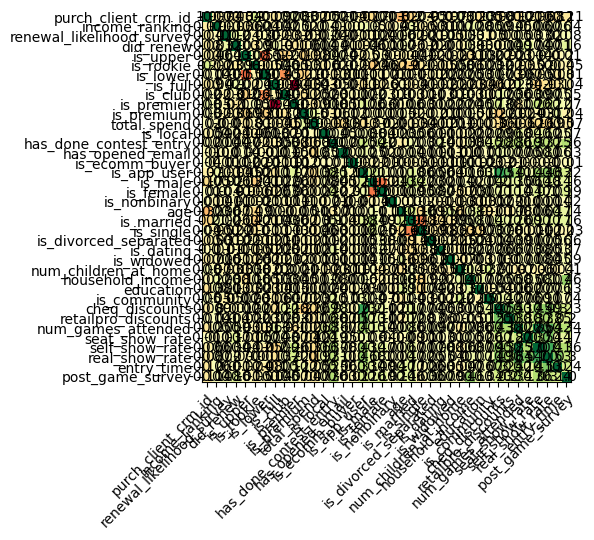

In [10]:
create_correlation_matrix(df_2324)

Interaction Variables: If certain variables are highly correclated you can comhbine them or variables of that share similar data to create one variable. (ie. Attendance, Spend, Affinity, or Engagement scores)

### __3. Training & Running Model__

#### __3.1__ Split data into train and test tables

Sometimes the split will be on season, othertimes train_test_split from sklearn can be used.

train_test_split info: https://scikit-learn.org/stable/modules/generated/sklearn.model_selection.train_test_split.html

In [11]:
df_2324 = df[df['season'] == '2023-24']
df_2425 = df[df['season'] == '2024-25']

x_train = df_2324.drop(labels = ['season','did_renew','purch_client_crm_id'], axis = 1)
y = df_2324[['did_renew']]

x_test = df_2425.drop(labels = ['season','did_renew','purch_client_crm_id'], axis = 1)
acct_ids = df_2425[['purch_client_crm_id']]

#### __3.2__ Write Model

Model selection is very important, first you must figure out what your output variable you want which tells you what kind of model you want (classification, clustering, regression). Then you can look at specific model types in that model group. 

Sometimes multiple will need to be tested before settling on the best model for your current data and situation.

Model selection info: https://scikit-learn.org/stable/modules/generated/sklearn.model_selection.train_test_split.html

In [12]:
# create monte carlo simulation for model

def run_log_reg(ticket_type, x_train, x_test, y, acct_ids, num_simulations):

    ss = StandardScaler()
    x_train_scaler = ss.fit_transform(x_train)
    x_test_scaler = ss.fit_transform(x_test)

    #if ticket_type == 'Full':
    #    weights = [1,1,2,2,1,1,1,1,2]
    #else:
    #    weights = [1,1,1.5,1.5,1,1,1,1,2]
    #x_train_scaler = x_train_scaler*weights
    #x_test_scaler = x_test_scaler*weights

    predicted_probs = np.zeros((x_test_scaler.shape[0], num_simulations))

    for i in range(num_simulations):

        logi = LogisticRegression(class_weight='balanced').fit(x_train_scaler, np.array(y))
        predicted_probs[:,i] = logi.predict_proba(x_test_scaler)[:,1]
    
    avg_predicted_probs = np.mean(predicted_probs, axis = 1)

    result_df = x_test
    result_df['avg_predicted_prob'] = avg_predicted_probs
    result_df = pd.concat([acct_ids, result_df], axis = 1)

    return result_df

#### __3.3__ Run Model

In [13]:
# run Full model

#full_final_df = run_log_reg('Full', x_train, x_test, y, acct_ids, 1000)

#subtract = [random.uniform(.09, .11) for i in range(len(full_final_df))]

#full_final_df['avg_predicted_prob'] = [value - subtract_value if value >= 0.12 else value for value, subtract_value in zip(full_final_df['avg_predicted_prob'], subtract)]

#full_final_df['ticket_type'] = 'Full'

### __4. Model Evaluation__

#### __4.1__ Classification Reports

(For classification models) Run classification report to see precision, recall, and fl score breakdown by group\

Classification report info: https://scikit-learn.org/stable/modules/generated/sklearn.metrics.classification_report.html

In [14]:
def run_classification_report(x,y):

    logi = LogisticRegression().fit(x, np.array(y))

    predicted = logi.predict(x)

    print(classification_report(predicted, y))

In [15]:
run_classification_report(x_train, y)

              precision    recall  f1-score   support

           0       0.00      0.00      0.00         0
           1       1.00      0.90      0.95      4107

    accuracy                           0.90      4107
   macro avg       0.50      0.45      0.47      4107
weighted avg       1.00      0.90      0.95      4107



c:\Users\riffere\Documents\pandas_party\venv\Lib\site-packages\sklearn\utils\validation.py:1339: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
c:\Users\riffere\Documents\pandas_party\venv\Lib\site-packages\sklearn\linear_model\_logistic.py:469: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(
c:\Users\riffere\Documents\pandas_party\venv\Lib\site-packages\sklearn\metrics\_classification.py:1531: UndefinedMetricWarning: Recall is ill-defined and being set to 0.0 in labels

#### __4.2__ Recursive Feature Elimination

Use Recursive Feature Elimination (with cross validation) to order the variables on most important to the classification to the least important. 

Especially useful for large datasets when you want to limit the number of variables in your model.

Below is a plot of the mean accuracy based on every possible number of features used in the model. 

It can be used to determine the optimal number of features without outside constraints placed on the model.

RFECV info: https://scikit-learn.org/stable/modules/generated/sklearn.feature_selection.RFECV.html

In [18]:
def run_rfe(estimator, step, scoring, x, y, show_plot):
    
    selector = RFECV(estimator = estimator, step = step, scoring = scoring)
    selector.fit(x, np.array(y)).n_features_

    rfe_features = x.columns[selector.support_]

    if show_plot == True:

        cv_results = pd.DataFrame(selector.cv_results_)
        
        plt.figure()
        plt.xlabel("Number of features selected")
        plt.ylabel("Mean test accuracy")

        plt.errorbar(
        x=cv_results["n_features"],
        y=cv_results["mean_test_score"],
        yerr=cv_results["std_test_score"],
            )
        
        plt.title("Recursive Feature Elimination \nwith correlated features")
        plt.show()

    return cv_results

c:\Users\riffere\Documents\pandas_party\venv\Lib\site-packages\sklearn\utils\validation.py:1339: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
c:\Users\riffere\Documents\pandas_party\venv\Lib\site-packages\sklearn\linear_model\_logistic.py:469: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(
c:\Users\riffere\Documents\pandas_party\venv\Lib\site-packages\sklearn\utils\validation.py:1339: DataConversionWarning: A column-vector y was passed when a 1d array was expected. P

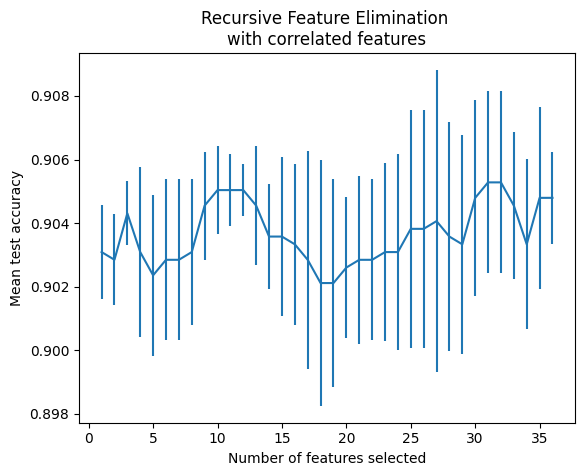

,mean_test_score,std_test_score,split0_test_score,split1_test_score,split2_test_score,split3_test_score,split4_test_score,n_features
0,0.903092,0.001486,0.903893,0.903893,0.900122,0.903776,0.903776,1
1,0.902849,0.001434,0.903893,0.902676,0.900122,0.903776,0.903776,2
2,0.904309,0.001010,0.905109,0.905109,0.903776,0.904994,0.902558,3
3,0.903091,0.002669,0.905109,0.906326,0.898904,0.903776,0.901340,4
4,0.902360,0.002534,0.903893,0.906326,0.898904,0.901340,0.901340,5
5,0.902848,0.002525,0.903893,0.906326,0.898904,0.903776,0.901340,6
6,0.902848,0.002525,0.903893,0.906326,0.898904,0.903776,0.901340,7
7,0.903091,0.002299,0.905109,0.905109,0.898904,0.903776,0.902558,8
8,0.904552,0.001699,0.905109,0.907543,0.903776,0.903776,0.902558,9
9,0.905040,0.001376,0.905109,0.907543,0.903776,0.904994,0.903776,10


In [19]:
run_rfe(LogisticRegression(), 1, 'accuracy', x_train, y, True)

#### __4.3__ Coefficient & Odds Ratio

Similar to RFE, Coefficient & Odds Ratio order the variables by importance. 

Can compare to RFE to see the variables both say are most important.

In [22]:
def get_coeff_odds_ratio(x, y):

    logi = LogisticRegression().fit(x, np.array(y))

    # Coefficients and Odds Ratios
    coefficients = logi.coef_[0]
    odds_ratios = np.exp(coefficients)


    # Display feature importance using coefficients and odds ratios
    feature_importance = pd.DataFrame({
        'Feature': x_train.columns,
        'Coefficient': coefficients,
        'Odds Ratio': odds_ratios
    })
    print("\nFeature Importance (Coefficient and Odds Ratio):")
    print(feature_importance.sort_values(by='Coefficient', ascending=False))

In [23]:
get_coeff_odds_ratio(x_train, y)


Feature Importance (Coefficient and Odds Ratio):
                      Feature  Coefficient  Odds Ratio
35           post_game_survey     0.573177    1.773893
1   renewal_likelihood_survey     0.307493    1.360011
5                     is_full     0.295389    1.343649
31             seat_show_rate     0.144761    1.155763
15                    is_male     0.112565    1.119145
2                    is_upper     0.109486    1.115704
25           household_income     0.072125    1.074790
19                 is_married     0.071129    1.073720
4                    is_lower     0.045778    1.046842
33             real_show_rate     0.044023    1.045006
10                   is_local     0.033561    1.034131
30         num_games_attended     0.030519    1.030990
18                        age     0.026307    1.026656
29        retailpro_discounts     0.020781    1.020998
12           has_opened_email     0.007985    1.008017
20                  is_single     0.006997    1.007021
17             

c:\Users\riffere\Documents\pandas_party\venv\Lib\site-packages\sklearn\utils\validation.py:1339: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
c:\Users\riffere\Documents\pandas_party\venv\Lib\site-packages\sklearn\linear_model\_logistic.py:469: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


#### __4.4__ Grid Search

Grid Search for Hyperparameters to optimize accuracy and precision.

Grid search info: https://scikit-learn.org/stable/modules/generated/sklearn.model_selection.GridSearchCV.html

In [24]:
def grid_search(C, penalty, class_weight, solver, x, y):

    param_grid = {'C': C,  
              'penalty': penalty, 
              'class_weight' : class_weight,
              'solver' : solver} 

    grid = GridSearchCV(LogisticRegression(), param_grid, refit = True, verbose = 3,n_jobs=-1) 
   
    # fitting the model for grid search 
    grid.fit(x, y) 
 
    # print best parameter after tuning 
    print(grid.best_params_) 
    grid_predictions = grid.predict(x) 
   
    # print classification report 
    print(classification_report(y, grid_predictions)) 

In [25]:
grid_search([0.1, 1, 10, 100], ['l1', 'l2', 'elasticnet'], ['balanced'], ['lbfgs', 'liblinear', 'newton-cg', 'newton-cholesky', 'sag', 'saga'], x_train, y)

Fitting 5 folds for each of 72 candidates, totalling 360 fits
{'C': 0.1, 'class_weight': 'balanced', 'penalty': 'l1', 'solver': 'saga'}
              precision    recall  f1-score   support

           0       0.00      0.00      0.00       394
           1       0.90      1.00      0.95      3713

    accuracy                           0.90      4107
   macro avg       0.45      0.50      0.47      4107
weighted avg       0.82      0.90      0.86      4107



c:\Users\riffere\Documents\pandas_party\venv\Lib\site-packages\sklearn\model_selection\_validation.py:540: FitFailedWarning: 
200 fits failed out of a total of 360.
The score on these train-test partitions for these parameters will be set to nan.
If these failures are not expected, you can try to debug them by setting error_score='raise'.

Below are more details about the failures:
--------------------------------------------------------------------------------
20 fits failed with the following error:
Traceback (most recent call last):
  File "c:\Users\riffere\Documents\pandas_party\venv\Lib\site-packages\sklearn\model_selection\_validation.py", line 888, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "c:\Users\riffere\Documents\pandas_party\venv\Lib\site-packages\sklearn\base.py", line 1473, in wrapper
    return fit_method(estimator, *args, **kwargs)
           ^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^
  File "c:\Users\riffere\Documents\pandas_party\venv\Lib\

#### __4.5__ AUC/ROC

AUC/ROC score and confusion matrix to see True/False Positives/Negatives

AUC/ROC info: https://scikit-learn.org/stable/modules/generated/sklearn.metrics.roc_auc_score.html

In [26]:
def auc_roc(x, y, display_labels):

    logi = LogisticRegression().fit(x, np.array(y))
    predicted = logi.predict(x)

    roc_auc_score(predicted, y)

    disp = ConfusionMatrixDisplay(confusion_matrix(predicted, y), display_labels= display_labels)
    disp.plot()

    plt.show()

In [27]:
auc_roc(x_train, y, ['Non-renewed', 'Renewed'])

c:\Users\riffere\Documents\pandas_party\venv\Lib\site-packages\sklearn\utils\validation.py:1339: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
c:\Users\riffere\Documents\pandas_party\venv\Lib\site-packages\sklearn\linear_model\_logistic.py:469: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


ValueError: Only one class present in y_true. ROC AUC score is not defined in that case.

### __5. Model Tuning__

#### __5.1__ Feature Elimination 

Use only variables from RFE and Coefficient and Odds ratio say are most important.

In [33]:
df_2324 = df[df['season'] == '2023-24']
df_2425 = df[df['season'] == '2024-25']

x_train = df_2324[['income_ranking', 'renewal_likelihood_survey', 'is_upper', 'is_rookie',
       'is_lower', 'is_full', 'is_club', 'is_premier', 'is_premium',
       'is_local', 'has_done_contest_entry', 'has_opened_email']]
y = df_2324[['did_renew']]

x_test = df_2425[['income_ranking', 'renewal_likelihood_survey', 'is_upper', 'is_rookie',
       'is_lower', 'is_full', 'is_club', 'is_premier', 'is_premium',
       'is_local', 'has_done_contest_entry', 'has_opened_email']]
acct_ids = df_2425[['purch_client_crm_id']]

In [35]:
run_classification_report(x_train, y)

              precision    recall  f1-score   support

           0       0.01      0.29      0.01         7
           1       1.00      0.90      0.95      4100

    accuracy                           0.90      4107
   macro avg       0.50      0.60      0.48      4107
weighted avg       1.00      0.90      0.95      4107



c:\Users\riffere\Documents\pandas_party\venv\Lib\site-packages\sklearn\utils\validation.py:1339: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


#### __5.2__ SMOTE (Synthetic Minority Over-sampling Technique) 

In cases where one class of data is much smaller than the other you can use SMOTE to create new fake data in the smaller class to balance them out and run a more accurate model. 

In [ ]:
def smote(k_neighbors, x, y):

    sm = SMOTE(random_state=1993, k_neighbors=k_neighbors)

    X_res, y_res = sm.fit_resample(x, y)

    logi = LogisticRegression().fit(X_res, np.array(y_res))

    predicted = logi.predict(X_res)

    print(classification_report(predicted, y_res))




    

In [39]:
smote(5, x_train, y)

              precision    recall  f1-score   support

           0       0.64      0.63      0.64      3751
           1       0.63      0.64      0.63      3675

    accuracy                           0.63      7426
   macro avg       0.63      0.63      0.63      7426
weighted avg       0.63      0.63      0.63      7426



c:\Users\riffere\Documents\pandas_party\venv\Lib\site-packages\sklearn\utils\validation.py:1339: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


#### __5.3__ Re-run Evaluation Techniques

Rerun RFE, grid search, and AUC/ROC to see if best variables and hyperparameters have changed and rerun the model

In [40]:
run_rfe(LogisticRegression(), 1, 'accuracy', x_train, y, False)

c:\Users\riffere\Documents\pandas_party\venv\Lib\site-packages\sklearn\utils\validation.py:1339: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
c:\Users\riffere\Documents\pandas_party\venv\Lib\site-packages\sklearn\utils\validation.py:1339: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
c:\Users\riffere\Documents\pandas_party\venv\Lib\site-packages\sklearn\utils\validation.py:1339: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
c:\Users\riffere\Documents\pandas_party\venv\Lib\site-packages\sklearn\utils\validation.py:1339: DataConversionWarning: A column-vector y was 

Index(['renewal_likelihood_survey', 'is_rookie', 'is_full'], dtype='object')

In [29]:
param_grid = {'C': [0.1, 1, 10, 100],  
              'penalty': ['l1', 'l2', 'elasticnet'], 
              'class_weight' : ['balanced'],
              'solver' : ['lbfgs', 'liblinear', 'newton-cg', 'newton-cholesky', 'sag', 'saga']} 

grid = GridSearchCV(LogisticRegression(), param_grid, refit = True, verbose = 3,n_jobs=-1) 
   
# fitting the model for grid search 
grid.fit(X_res, y_res) 
 
# print best parameter after tuning 
print(grid.best_params_) 
grid_predictions = grid.predict(X_res) 
   
# print classification report 
print(classification_report(y_res, grid_predictions)) 

Fitting 5 folds for each of 72 candidates, totalling 360 fits
{'C': 10, 'class_weight': 'balanced', 'penalty': 'l2', 'solver': 'liblinear'}
              precision    recall  f1-score   support

           0       0.84      0.84      0.84      3713
           1       0.84      0.84      0.84      3713

    accuracy                           0.84      7426
   macro avg       0.84      0.84      0.84      7426
weighted avg       0.84      0.84      0.84      7426



c:\Users\riffere\Documents\pandas_party\venv\Lib\site-packages\sklearn\model_selection\_validation.py:540: FitFailedWarning: 
200 fits failed out of a total of 360.
The score on these train-test partitions for these parameters will be set to nan.
If these failures are not expected, you can try to debug them by setting error_score='raise'.

Below are more details about the failures:
--------------------------------------------------------------------------------
20 fits failed with the following error:
Traceback (most recent call last):
  File "c:\Users\riffere\Documents\pandas_party\venv\Lib\site-packages\sklearn\model_selection\_validation.py", line 888, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "c:\Users\riffere\Documents\pandas_party\venv\Lib\site-packages\sklearn\base.py", line 1473, in wrapper
    return fit_method(estimator, *args, **kwargs)
           ^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^
  File "c:\Users\riffere\Documents\pandas_party\venv\Lib\

c:\Users\riffere\Documents\pandas_party\venv\Lib\site-packages\sklearn\utils\validation.py:1339: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
c:\Users\riffere\Documents\pandas_party\venv\Lib\site-packages\sklearn\linear_model\_logistic.py:469: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


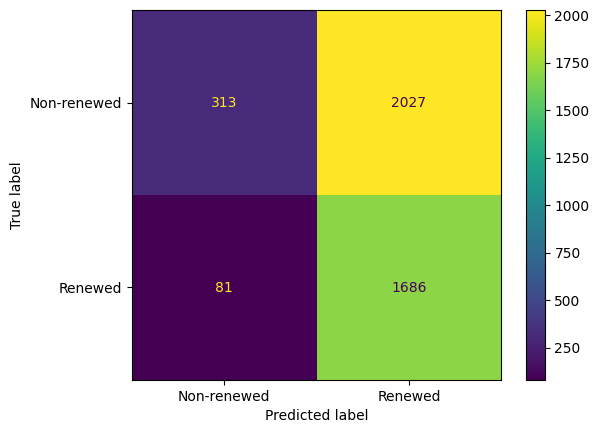

In [30]:
# AUC ROC

logi = LogisticRegression().fit(X_res, np.array(y_res))

predicted = logi.predict(x_train)

roc_auc_score(predicted, y)

# Confusion Matrix

disp = ConfusionMatrixDisplay(confusion_matrix(predicted, y), display_labels= ['Non-renewed', 'Renewed'])

disp.plot()

plt.show()

In [ ]:
# run Full model

predicted = logi.predict(x_test)

